# <center>Data Mining Project 2 Spring semester 2019-2020</center>
## <center>Παναγιώτης Ευαγγελίου &emsp; 1115201500039</center>
## <center>Γεώργιος Μαραγκοζάκης &emsp; 1115201500089</center>

___

### Do all the necessary imports for this notebook

In [1]:
# data processing
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords as nltkStopwords
from string import punctuation, digits
import re
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# visualization
from wordcloud import WordCloud
from IPython.display import Image
from IPython.display import display
from itertools import cycle
import matplotlib.patches as mpatches

# classification
from sklearn.model_selection import KFold
from sklearn import svm, preprocessing
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import scipy
from collections import Counter
import gensim 
import random
from operator import add

# vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# clustering
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn.decomposition import PCA

# for data exploration
import os
import numpy as np

## __Dataset Preprocessing__

- ### *Make tsv files from all the txt files*

In [2]:
myCategoriesFolder = ['business','entertainment','politics', 'sport', 'tech']
dataPathDir = './fulltext/data/'

myDataSetDf = pd.DataFrame(columns=['ID', 'TITLE',  'CONTENT',  'CATEGORY'])
id_count = 0

for category in myCategoriesFolder:
    specificPath = dataPathDir + category + '/'

    # find the column's names of each csv
    for fileName in os.listdir(specificPath):
        # we need to check only .txt files
        if fileName.endswith(".txt"):
            
            thisTxt = open(os.path.join(specificPath, fileName),"r")
            thisTxtTitle = thisTxt.readline()

            # get rid of '\n' on the end of title line
            thisTxtTitle = thisTxtTitle.replace('\n', '')

            thisTxtContent = thisTxt.readlines()

            # get rid of empty lines '\n'
            thisTxtContent = list(filter(lambda a: a != '\n', thisTxtContent))

            # get rid of '\n' on the end of each line 
            thisTxtContent = [period.replace('\n', '') for period in thisTxtContent]

            # convert list of lines into a single string line
            thisTxtContent = ' '.join(thisTxtContent)

            myDataSetDf = myDataSetDf.append({'ID': id_count, 'TITLE': thisTxtTitle, 'CONTENT': thisTxtContent, 'CATEGORY': category.upper()}, ignore_index=True)
            thisTxt.close()

            id_count += 1

display(myDataSetDf)

,ID,TITLE,CONTENT,CATEGORY
0,0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,BUSINESS
1,1,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,BUSINESS
2,2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,BUSINESS
3,3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,BUSINESS
4,4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,BUSINESS
...,...,...,...,...
2220,2220,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,TECH
2221,2221,Spam e-mails tempt net shoppers,Computer users across the world continue to ig...,TECH
2222,2222,Be careful how you code,A new European directive could put software wr...,TECH
2223,2223,US cyber security chief resigns,The man making sure US computer networks are s...,TECH


## __Make wordcloud for each category__

In [3]:
def makeWordCloud(myText, saveLocationPath, myMaxWords=100, myMask=None, myStopWords=None):
    '''Default function for generating wordcloud'''

    wc = WordCloud(background_color="white", mask=myMask, max_words=myMaxWords,
                   stopwords=myStopWords, contour_width=3, contour_color='steelblue',
                   width=600, height=600)

    # generate word cloud
    wc.generate(myText)

    # store to file

    wc.to_file(saveLocationPath)

    return saveLocationPath

In [4]:
def columnToText(myDfColumn):
    wholeColumnText = ''

    for text in myDfColumn:
        wholeColumnText = wholeColumnText + ' ' + text

    return wholeColumnText

In [5]:
stopWords = ENGLISH_STOP_WORDS
myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = (stopWords.union(myAdditionalStopWords))

- ### *Business Wordcloud*

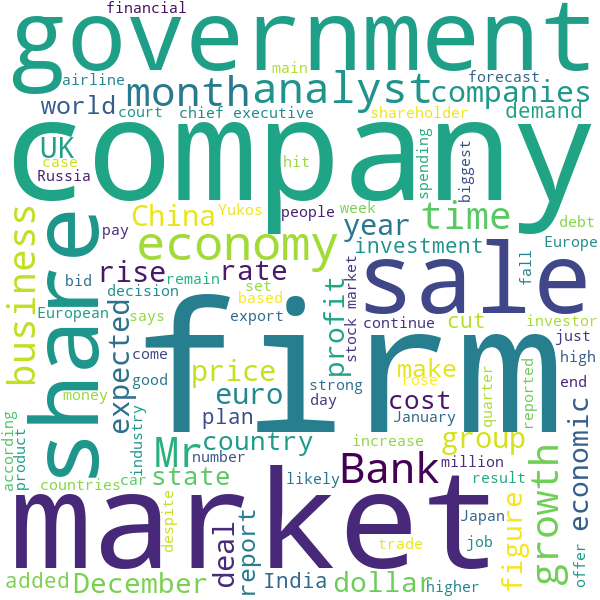

In [6]:
makeWordCloud(saveLocationPath="businessWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "BUSINESS"]['CONTENT']), myStopWords=stopWords)

Image('businessWordCloud.png')

- ### *Entertainment Wordcloud*

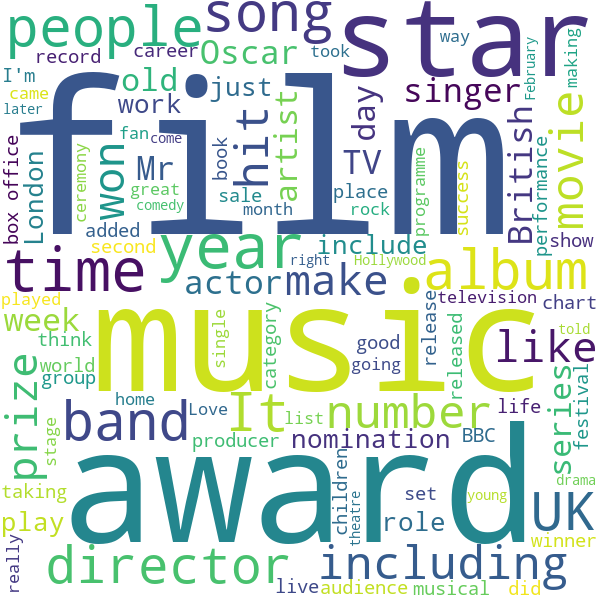

In [7]:
makeWordCloud(saveLocationPath="entertainmentWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "ENTERTAINMENT"]['CONTENT']), myStopWords=stopWords)

Image('entertainmentWordCloud.png')

- ### *Politics Wordcloud*

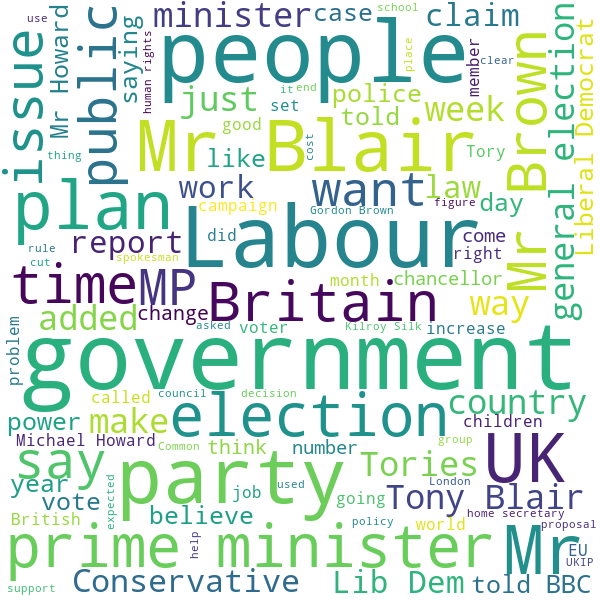

In [8]:
makeWordCloud(saveLocationPath="politicsWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "POLITICS"]['CONTENT']), myStopWords=stopWords)

Image('politicsWordCloud.png')

- ### *Sport Wordcloud*

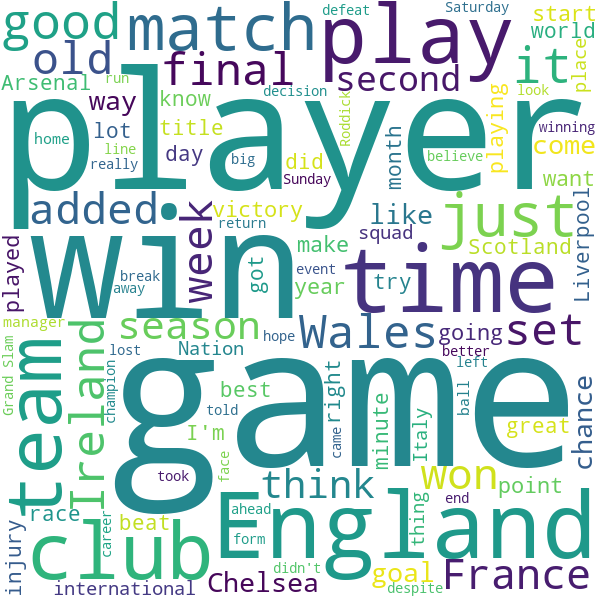

In [9]:
makeWordCloud(saveLocationPath="sportWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "SPORT"]['CONTENT']), myStopWords=stopWords)

Image('sportWordCloud.png')

- ### *Tech Wordcloud*

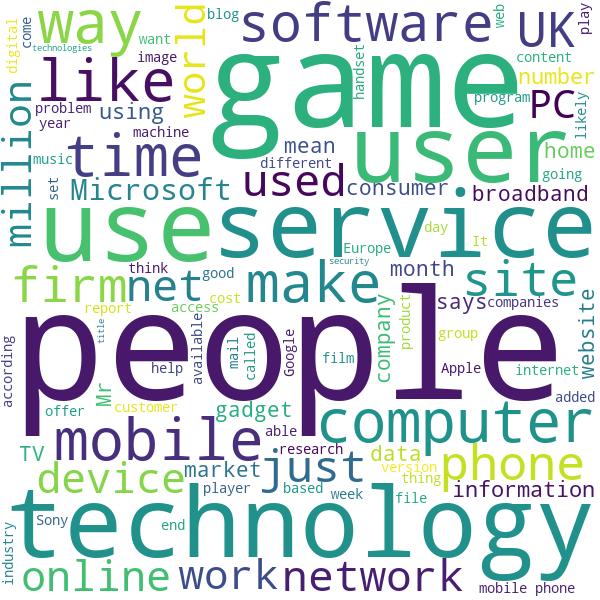

In [10]:
makeWordCloud(saveLocationPath="techWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "TECH"]['CONTENT']), myStopWords=stopWords)

Image('techWordCloud.png')

## __Classification__

In [11]:
def scoresReportCv(clf, trainX, trainY):
    """
    Printing scores using cross_val_score    
    """

    print('----Report for 10-fold Cross Validation----')

    precisions = cross_val_score(clf, trainX, trainY, cv=10, scoring='precision_weighted')
    print ('Precision \t %0.2f' % (np.mean(precisions)))

    recalls = cross_val_score(clf, trainX, trainY, cv=10, scoring='recall_weighted')
    print ('Recalls \t %0.2f' % (np.mean(recalls)))

    f1s = cross_val_score(clf, trainX, trainY, cv=10, scoring='f1_weighted')
    print ('F-Measure \t %0.2f' % (np.mean(f1s)))

    scores = cross_val_score(clf, trainX, trainY, cv=10)
    print("Accuracy: \t %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [12]:
def makeRocPlot(labelTest, predictions, labelEncoder):
    # Binarize the output
    labelsAsNumber = [i for i in range(0,len(labelEncoder.classes_))]
    labelTest = label_binarize(labelTest, classes=labelsAsNumber)
    n_classes = labelTest.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labelTest[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labelTest.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw = 2

    # Plot all ROC curves
    plt.figure(figsize=(12, 12))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'forestgreen', 'maroon'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(labelEncoder.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC plot of all classes')
    plt.legend(loc="lower right")
    plt.show()

  - #### Classification using SVM classifier

In [13]:
def SvmClassification(trainX, trainY, testX, testY, labelEncoder):
    """
    Classify the text using the SVM classifier of scikit-learn    
    """
    
    clf = svm.SVC(kernel='linear', C=1, probability=True)

    # fit train set
    clf.fit(trainX, trainY)
    
    # use 10-fold Cross Validation
    scoresReportCv(clf, trainX, trainY)

    # Predict test set
    predY = clf.predict(testX)

    # Classification_report
    print('\n----Report for predictions on test dataset----')
    print(classification_report(testY, predY, target_names=list(labelEncoder.classes_)))

    print('\n----ROC plot for predictions on test dataset----')
    y_score = clf.predict_proba(testX)

    makeRocPlot(testY, y_score, labelEncoder)

    return accuracy_score(testY, predY)

  - #### Classification using Random Forests classifier

In [14]:
def RandomForestClassification(trainX, trainY, testX, testY, labelEncoder):
    """
    Classify the text using the Random Forest classifier of scikit-learn    
    """
    
    clf = RandomForestClassifier()
        
    # fit train set
    clf.fit(trainX, trainY)
    
    # use 10-fold Cross Validation
    scoresReportCv(clf, trainX, trainY)

    # Predict test set
    predY = clf.predict(testX)

    # Classification_report
    print('\n----Report for predictions on test dataset----')
    print(classification_report(testY, predY, target_names=list(labelEncoder.classes_)))

    print('\n----ROC plot for predictions on test dataset----')
    y_score = clf.predict_proba(testX)

    makeRocPlot(testY, y_score, labelEncoder)

    return accuracy_score(testY, predY)

  - #### Classification using Naive Bayes classifier

In [15]:
def NaiveBayesClassification(trainX, trainY, testX, testY, labelEncoder):
    """
    Classify the text using the Naive Bayes classifier of scikit-learn    
    """

    clf = GaussianNB()
    
    trainX = trainX.toarray()
    
    # fit train set
    clf.fit(trainX, trainY)
    
    # use 10-fold Cross Validation
    scoresReportCv(clf, trainX, trainY)

    # Predict test set
    testX = testX.toarray()
    predY = clf.predict(testX)

    # Classification_report
    print('\n----Report for predictions on test dataset----')
    print(classification_report(testY, predY, target_names=list(labelEncoder.classes_)))

    print('\n----ROC plot for predictions on test dataset----')

    y_score = clf.predict_proba(testX)

    makeRocPlot(testY, y_score, labelEncoder)

    return accuracy_score(testY, predY)

  - #### Classification using K-Nearest Neighbor classifier

Our implemantion is based on this link https://towardsdatascience.com/k-nearest-neighbor-classifier-from-scratch-in-python-698e3de97063 
and this link https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

In [16]:
# calculate the Euclidean distance between two 1d-arrays
def distance(instance1, instance2):
    return scipy.spatial.distance.euclidean(instance1, instance2)

def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=distance):
    """
    get_neighors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where 
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = []
    for index in range(len(training_set)):
        dist = distance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors

# The function 'vote' returns the most common class. (Majority Voting)
def vote(neighbors):
    class_counter = Counter()
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1
    return class_counter.most_common(1)[0][0]

# Make a prediction with neighbors
def predict_classification(training_set, labels, test_instance, k, distance=distance):
    neighbors = get_neighbors(training_set, labels, test_instance, k, distance=distance)
    prediction = vote(neighbors)
    return prediction

# kNN Algorithm
def k_nearest_neighbors(trainX, trainY, testX, num_neighbors):
    predictions = list()
    for row in testX:
        output = predict_classification(trainX, trainY, row,  num_neighbors, distance=distance )
        predictions.append(output)
    return(predictions)

def KnnClassification(trainX, trainY, testX, testY, labelEncoder):
    """
    Classify the text using the KNN classifier we implemented   
    """

    trainXarray = trainX.toarray()
    testXarray = testX.toarray()

    predictions = k_nearest_neighbors(trainXarray, trainY, testXarray, 100)

    predY = np.asarray(predictions)

    # Classification_report
    print('\n----Report for predictions on test dataset----')
    print(classification_report(testY, predY, target_names=list(labelEncoder.classes_)))

    return accuracy_score(testY, predY)


- ### *Split DataSet into TrainData and TestData*

In [17]:
trainDataSet, testDataSet = train_test_split(myDataSetDf, test_size=0.2, stratify=myDataSetDf['CATEGORY'])

# reset index
trainDataSet.reset_index(drop=True, inplace=True)
testDataSet.reset_index(drop=True, inplace=True)

# save to tsv files
trainDataSet.to_csv('train_set.tsv', sep = '\t')

# save test_set categories
testDataSetCategories = testDataSet[['CATEGORY']].copy()

testDataSetCategories.to_csv('test_set_categories.tsv', sep = '\t')

testDataSet = testDataSet.drop('CATEGORY', axis=1)
testDataSet.to_csv('test_set.tsv', sep = '\t')

Prepare train and test data that we will need below

In [18]:
# build label encoder for categories
le = preprocessing.LabelEncoder()
le.fit(trainDataSet["CATEGORY"])

# transform categories into numbers
trainY = le.transform(trainDataSet["CATEGORY"])
testY = le.transform(testDataSetCategories["CATEGORY"])

accuracyDict = dict()

## __Vectorization__

Let's do classification using 2 different ways of vectorization

In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

  - #### Bag-of-words vectorization

-------------SVM Classification with BOW Vectorization-------------
----Report for 10-fold Cross Validation----
Precision 	 0.94
Recalls 	 0.94
F-Measure 	 0.94
Accuracy: 	 0.94 (+/- 0.03)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.97      0.92      0.94       102
ENTERTAINMENT       0.94      0.99      0.96        77
     POLITICS       0.98      0.96      0.97        84
        SPORT       0.97      0.99      0.98       102
         TECH       0.95      0.95      0.95        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445


----ROC plot for predictions on test dataset----


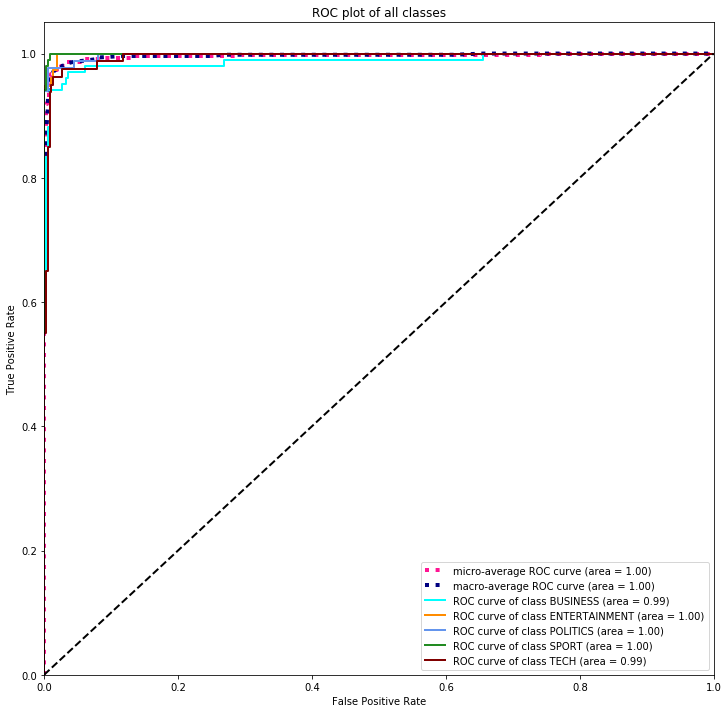


-------------Random Forests Classification with BOW Vectorization-------------
----Report for 10-fold Cross Validation----
Precision 	 0.95
Recalls 	 0.95
F-Measure 	 0.95
Accuracy: 	 0.94 (+/- 0.03)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.96      0.94      0.95       102
ENTERTAINMENT       0.99      0.97      0.98        77
     POLITICS       0.96      0.96      0.96        84
        SPORT       0.97      1.00      0.99       102
         TECH       0.96      0.96      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445


----ROC plot for predictions on test dataset----


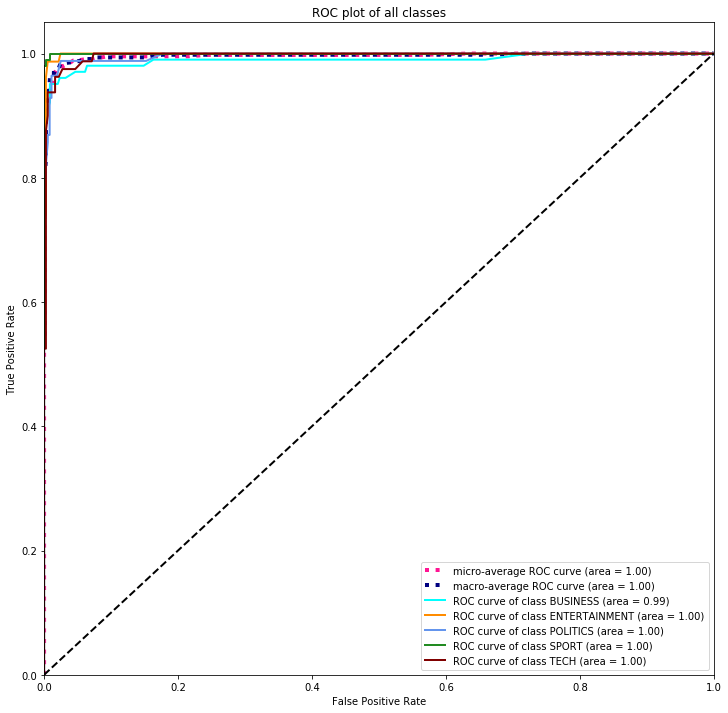


-------------Naive Bayes Classification with BOW Vectorization-------------
----Report for 10-fold Cross Validation----
Precision 	 0.91
Recalls 	 0.90
F-Measure 	 0.91
Accuracy: 	 0.90 (+/- 0.03)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.95      0.85      0.90       102
ENTERTAINMENT       0.87      0.90      0.88        77
     POLITICS       0.88      0.95      0.91        84
        SPORT       0.98      0.89      0.93       102
         TECH       0.82      0.93      0.87        80

     accuracy                           0.90       445
    macro avg       0.90      0.90      0.90       445
 weighted avg       0.91      0.90      0.90       445


----ROC plot for predictions on test dataset----


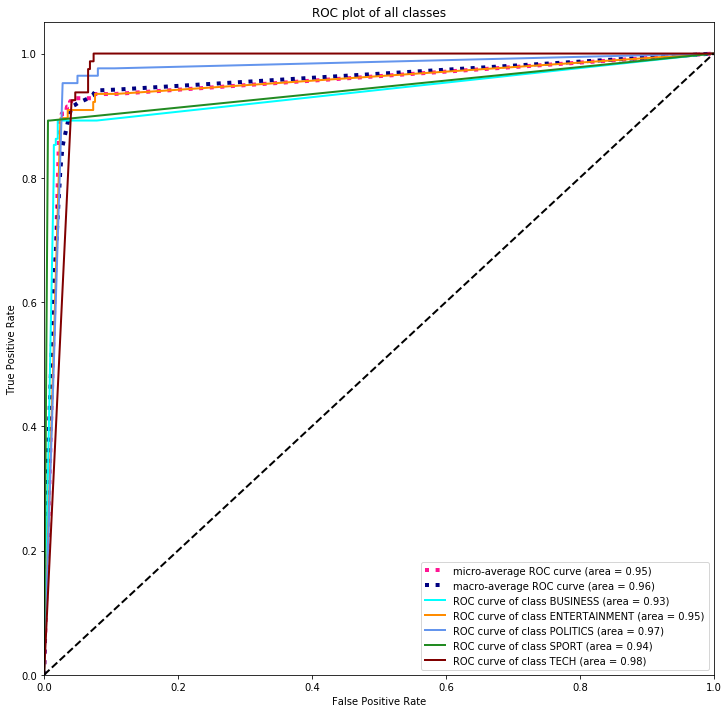


-------------K Nearest Neighbor Classification with BOW Vectorization-------------

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.55      0.84      0.67       102
ENTERTAINMENT       0.80      0.47      0.59        77
     POLITICS       0.84      0.62      0.71        84
        SPORT       0.68      0.86      0.76       102
         TECH       0.83      0.55      0.66        80

     accuracy                           0.69       445
    macro avg       0.74      0.67      0.68       445
 weighted avg       0.73      0.69      0.68       445



In [20]:
bowVectorizer = CountVectorizer(max_features=1000)

trainX = bowVectorizer.fit_transform(trainDataSet['CONTENT'])
testX = bowVectorizer.transform(testDataSet['CONTENT'])

print('-------------SVM Classification with BOW Vectorization-------------')
accuracyDict["BOW-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)

print('\n-------------Random Forests Classification with BOW Vectorization-------------')
accuracyDict["BOW-RandomForests"] = RandomForestClassification(trainX, trainY, testX, testY, le)

print('\n-------------Naive Bayes Classification with BOW Vectorization-------------')
accuracyDict["BOW-NB"] = NaiveBayesClassification(trainX, trainY, testX, testY, le)

print('\n-------------K Nearest Neighbor Classification with BOW Vectorization-------------')
accuracyDict["BOW-knn"] = KnnClassification(trainX, trainY, testX, testY, le)

  - #### Tf-idf vectorization

-------------SVM Classification with TfIdf Vectorization-------------
----Report for 10-fold Cross Validation----
Precision 	 0.97
Recalls 	 0.97
F-Measure 	 0.97
Accuracy: 	 0.97 (+/- 0.02)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.98      0.95      0.97       102
ENTERTAINMENT       0.96      0.99      0.97        77
     POLITICS       1.00      0.99      0.99        84
        SPORT       0.98      1.00      0.99       102
         TECH       0.95      0.95      0.95        80

     accuracy                           0.98       445
    macro avg       0.97      0.98      0.97       445
 weighted avg       0.98      0.98      0.98       445


----ROC plot for predictions on test dataset----


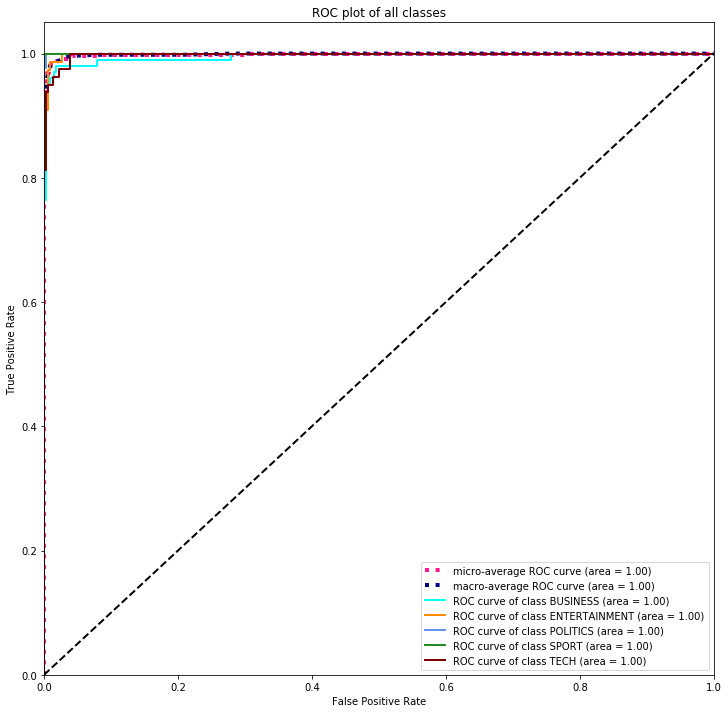


-------------Random Forests Classification with TfIdf Vectorization-------------
----Report for 10-fold Cross Validation----
Precision 	 0.95
Recalls 	 0.95
F-Measure 	 0.95
Accuracy: 	 0.95 (+/- 0.03)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.93      0.92      0.93       102
ENTERTAINMENT       0.95      0.96      0.95        77
     POLITICS       0.98      0.95      0.96        84
        SPORT       0.98      1.00      0.99       102
         TECH       0.94      0.94      0.94        80

     accuracy                           0.96       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.96      0.95       445


----ROC plot for predictions on test dataset----


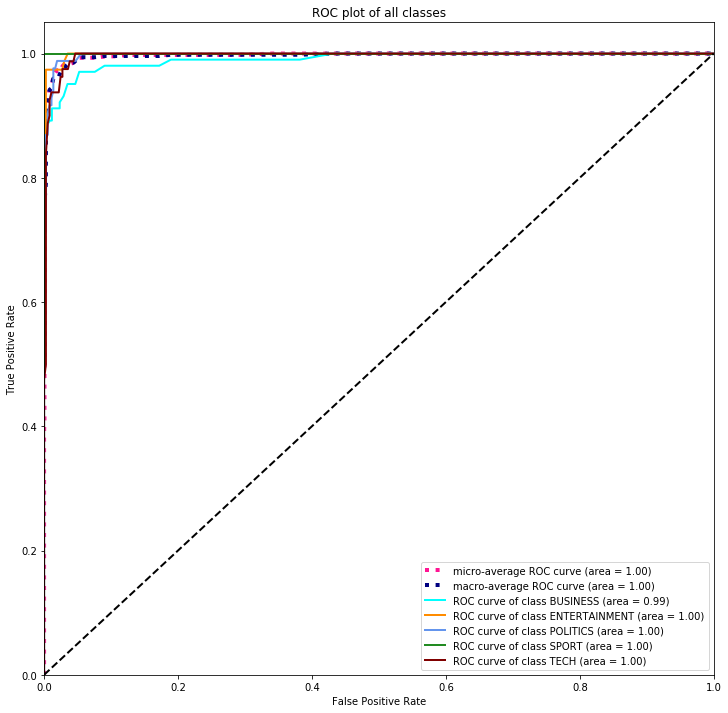


-------------Naive Bayes Classification with TfIdf Vectorization-------------
----Report for 10-fold Cross Validation----
Precision 	 0.90
Recalls 	 0.90
F-Measure 	 0.90
Accuracy: 	 0.90 (+/- 0.04)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.89      0.86      0.88       102
ENTERTAINMENT       0.84      0.90      0.87        77
     POLITICS       0.91      0.94      0.92        84
        SPORT       0.99      0.87      0.93       102
         TECH       0.84      0.91      0.87        80

     accuracy                           0.89       445
    macro avg       0.89      0.90      0.89       445
 weighted avg       0.90      0.89      0.89       445


----ROC plot for predictions on test dataset----


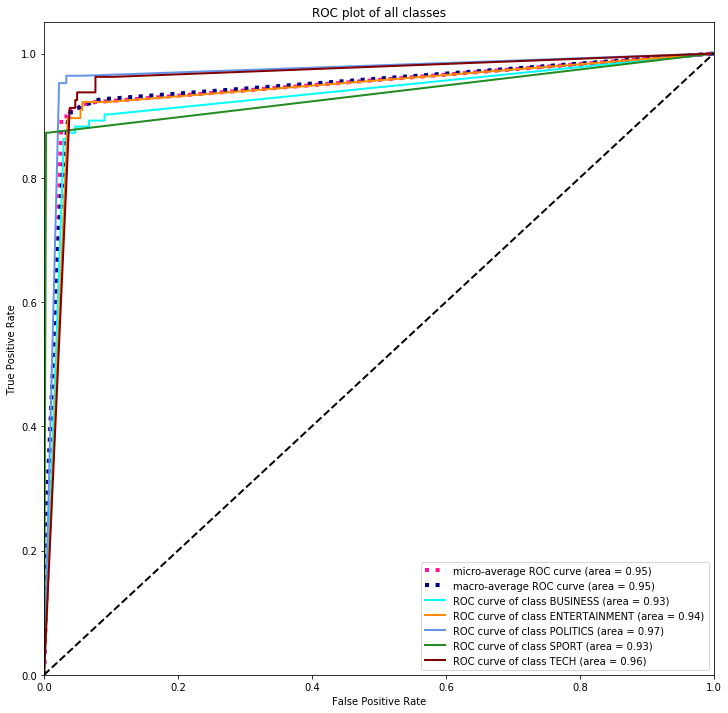


-------------K Nearest Neighbor Classification with TfIdf Vectorization-------------

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.99      0.82      0.90       102
ENTERTAINMENT       1.00      0.90      0.95        77
     POLITICS       0.95      0.96      0.96        84
        SPORT       0.97      1.00      0.99       102
         TECH       0.77      0.97      0.86        80

     accuracy                           0.93       445
    macro avg       0.94      0.93      0.93       445
 weighted avg       0.94      0.93      0.93       445



In [21]:
tfIdfVectorizer = TfidfVectorizer(max_features=1000)

trainX = tfIdfVectorizer.fit_transform(trainDataSet['CONTENT'])
testX = tfIdfVectorizer.transform(testDataSet['CONTENT'])

print('-------------SVM Classification with TfIdf Vectorization-------------')
accuracyDict["TfIdf-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)

print('\n-------------Random Forests Classification with TfIdf Vectorization-------------')
accuracyDict["TfIdf-RandomForests"] = RandomForestClassification(trainX, trainY, testX, testY, le)

print('\n-------------Naive Bayes Classification with TfIdf Vectorization-------------')
accuracyDict["TfIdf-NB"] = NaiveBayesClassification(trainX, trainY, testX, testY, le)

print('\n-------------K Nearest Neighbor Classification with TfIdf Vectorization-------------')
accuracyDict["TfIdf-knn"] = KnnClassification(trainX, trainY, testX, testY, le)

  #### Results Summary

In [22]:
resultsData = {r'Vectorizer \ Classifier': ['BOW', 'Tfidf'],
               'SVM': [accuracyDict["BOW-SVM"], accuracyDict["TfIdf-SVM"]],
               'Random Forest': [accuracyDict["BOW-RandomForests"], accuracyDict["TfIdf-RandomForests"]],
               'Naive Bayes': [accuracyDict["BOW-NB"], accuracyDict["TfIdf-NB"]],
               'K Nearest Neighbor': [accuracyDict["BOW-knn"], accuracyDict["TfIdf-knn"]]}

resultsDataFrame = pd.DataFrame(data=resultsData)

resultsDataFrame

,Vectorizer \ Classifier,SVM,Random Forest,Naive Bayes,K Nearest Neighbor
0,BOW,0.961798,0.968539,0.901124,0.687640
1,Tfidf,0.975281,0.955056,0.894382,0.930337


## __Beat the Benchmark (bonus)__

In [23]:
def preprocessText(initText):
    """Preprocess the text"""

    # Make everything to lower case
    processedText = initText.lower()

    # Remove urls
    processedText = re.sub(r'(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)'
                           r'*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?', ' ', processedText)

    # Remove any punctuation from the text
    for c in punctuation:
        processedText = processedText.replace(c, ' ')

    # Remove digits
    processedText = re.sub(r'\d+', '', processedText)

    # Remove consecutive spaces
    processedText = re.sub(r" {2,}", ' ', processedText)    

    # Split to words
    tokens = word_tokenize(processedText)

    # Remove sropwords
    stopWords = ENGLISH_STOP_WORDS
    stopWords = (stopWords.union(nltkStopwords.words('english')))
    filtered = [w for w in tokens if w not in stopWords]

    # Concat the remaining words in a single string again
    if not filtered:  # list is empty
        processedText = ''
    else:
        processedText = filtered[0]
        for word in filtered[1:]:
            processedText = processedText + ' ' + word

    return processedText

def stemmingPreprocess(initText):
    # Split to words
    tokens = word_tokenize(initText)

    # Do the stemming
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in tokens]

    # Concat the remaining words in a single string again
    if not stems:  # list is empty
        processedText = ''
    else:
        processedText = stems[0]
        for stem in stems[1:]:
            processedText = processedText + ' ' + stem

    return processedText

Let's do some preprocessing for train and test data

In [24]:
trainDataPreprocessed = trainDataSet.copy()
testDataPreprocessed = testDataSet.copy()

# preprocess train data
for index, row in trainDataPreprocessed.iterrows():
    initialText = row["CONTENT"]
    trainDataPreprocessed.iloc[index]["CONTENT"] = preprocessText(initialText)

# preprocess test data
for index, row in testDataPreprocessed.iterrows():
    initialText = row["CONTENT"]
    testDataPreprocessed.iloc[index]["CONTENT"] = preprocessText(initialText)

Let's do stemming

In [25]:
for index, row in trainDataPreprocessed.iterrows():
    initialText = row["CONTENT"]
    trainDataPreprocessed.iloc[index]["CONTENT"] = stemmingPreprocess(initialText)

for index, row in testDataPreprocessed.iterrows():
    initialText = row["CONTENT"]
    testDataPreprocessed.iloc[index]["CONTENT"] = stemmingPreprocess(initialText)

We will check only the SVM classifier with Tf-idf vectorization


-------------SVM Classification with TfIdf Vectorization in processed text-------------
----Report for 10-fold Cross Validation----
Precision 	 0.97
Recalls 	 0.97
F-Measure 	 0.97
Accuracy: 	 0.97 (+/- 0.03)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.96      0.95      0.96       102
ENTERTAINMENT       0.97      0.97      0.97        77
     POLITICS       0.98      0.99      0.98        84
        SPORT       1.00      1.00      1.00       102
         TECH       0.95      0.95      0.95        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445


----ROC plot for predictions on test dataset----


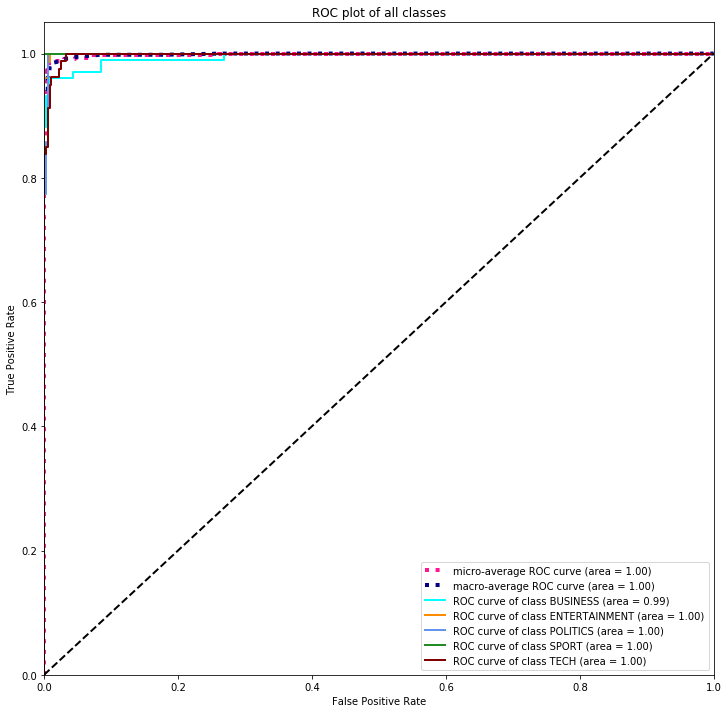

In [26]:
tfIdfVectorizer = TfidfVectorizer(max_features=1000)

trainX = tfIdfVectorizer.fit_transform(trainDataPreprocessed['CONTENT'])
testX = tfIdfVectorizer.transform(testDataPreprocessed['CONTENT'])

print('\n-------------SVM Classification with TfIdf Vectorization in processed text-------------')
accuracyDict["TfIdf-SVM-processed"] = SvmClassification(trainX, trainY, testX, testY, le)

Let's compare scores

In [27]:
resultsDataCompare = {'SVM without preprocessing': [accuracyDict["TfIdf-SVM"]],
               'SVM with preprocessing': [accuracyDict["TfIdf-SVM-processed"]]}

resultsCompareDataFrame = pd.DataFrame(data=resultsDataCompare)

resultsCompareDataFrame

,SVM without preprocessing,SVM with preprocessing
0,0.975281,0.973034


As we see there is no big difference between scores for max_features=1000 in TfidfVectorizer. 
Let's check what happens for max_features=100

In [28]:
tfIdfVectorizer = TfidfVectorizer(max_features=100)

-------------SVM Classification with TfIdf Vectorization for max_features=100-------------
----Report for 10-fold Cross Validation----
Precision 	 0.82
Recalls 	 0.82
F-Measure 	 0.82
Accuracy: 	 0.82 (+/- 0.06)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.80      0.82      0.81       102
ENTERTAINMENT       0.91      0.81      0.86        77
     POLITICS       0.88      0.87      0.87        84
        SPORT       0.88      0.95      0.92       102
         TECH       0.78      0.78      0.78        80

     accuracy                           0.85       445
    macro avg       0.85      0.84      0.85       445
 weighted avg       0.85      0.85      0.85       445


----ROC plot for predictions on test dataset----


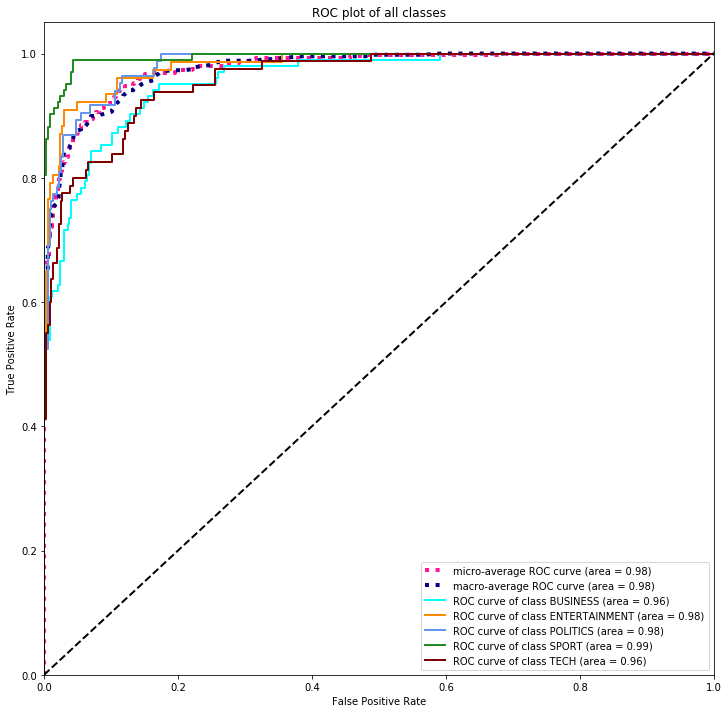

In [29]:
trainX = tfIdfVectorizer.fit_transform(trainDataSet['CONTENT'])
testX = tfIdfVectorizer.transform(testDataSet['CONTENT'])

print('-------------SVM Classification with TfIdf Vectorization for max_features=100-------------')
accuracyDict["TfIdf-SVM-100"] = SvmClassification(trainX, trainY, testX, testY, le)


-------------SVM Classification with TfIdf Vectorization in processed text for max_features=100-------------
----Report for 10-fold Cross Validation----
Precision 	 0.90
Recalls 	 0.89
F-Measure 	 0.89
Accuracy: 	 0.89 (+/- 0.04)

----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.93      0.87      0.90       102
ENTERTAINMENT       0.89      0.94      0.91        77
     POLITICS       0.92      0.96      0.94        84
        SPORT       0.96      0.96      0.96       102
         TECH       0.88      0.86      0.87        80

     accuracy                           0.92       445
    macro avg       0.92      0.92      0.92       445
 weighted avg       0.92      0.92      0.92       445


----ROC plot for predictions on test dataset----


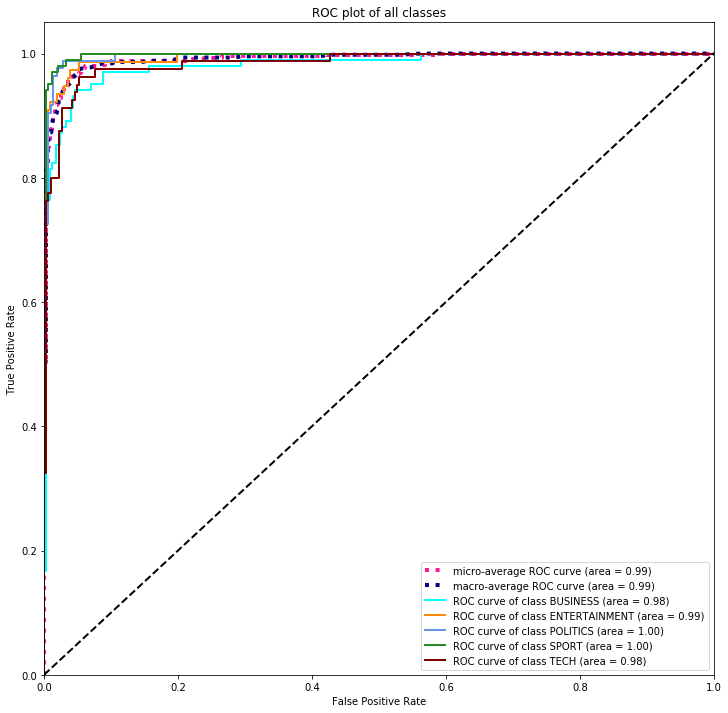

In [30]:
trainX = tfIdfVectorizer.fit_transform(trainDataPreprocessed['CONTENT'])
testX = tfIdfVectorizer.transform(testDataPreprocessed['CONTENT'])

print('\n-------------SVM Classification with TfIdf Vectorization in processed text for max_features=100-------------')
accuracyDict["TfIdf-SVM-processed-100"] = SvmClassification(trainX, trainY, testX, testY, le)

Let's compare scores one more time

In [31]:
resultsDataCompare = {'SVM without preprocessing for max_features=100': [accuracyDict["TfIdf-SVM-100"]],
                      'SVM with preprocessing for max_features=100': [accuracyDict["TfIdf-SVM-processed-100"]]}

resultsCompareDataFrame = pd.DataFrame(data=resultsDataCompare)

resultsCompareDataFrame

,SVM without preprocessing for max_features=100,SVM with preprocessing for max_features=100
0,0.849438,0.919101


Here we can see a significant difference.

## __Clustering__

In [32]:
def KmeansClustering(trainX, numberOfClusters, numberOfRepeats):
    # init cluster with trainX
    # maybe init with something smarter than none ? https://datascience.stackexchange.com/questions/5656/k-means-what-are-some-good-ways-to-choose-an-efficient-set-of-initial-centroids
    clusterer = KMeansClusterer(numberOfClusters, cosine_distance, initial_means=None, repeats=numberOfRepeats)
    assigned_clusters = clusterer.cluster(trainX, assign_clusters=True)
    return clusterer, assigned_clusters

- #### Compression using PCA method

In [33]:
def principalComponentAnalysis(nComponents, trainX, labels, clusters):
    # reduce the features to 2D
    random_state = 0 
    pca = PCA(n_components=nComponents, random_state=random_state)

    #reduced_features = pca.fit_transform(trainX.toarray())
    reduced_features = pca.fit_transform(trainX)

    # reduce the cluster centers to 2D
    reduced_cluster_centers = pca.transform(labels._means)

    # assign specific marker shape for each true category
    markers = ["o" , "v" , "P" , "s", "*"]
    colors = ["tab:blue" , "tab:orange" , "tab:green" , "tab:red", "tab:purple"]

    specificMarkers = list()
    specificColors = list()

    for i in range(0,trainX.shape[0]):
        specificMarkers.append(markers[trainY[i]])
        specificColors.append(colors[clusters[i]])

    plt.figure(figsize=(12, 12))
 
    xArray = reduced_features[:,0]
    yArray = reduced_features[:,1]

    for i in range(0,len(clusters)):
        plt.scatter(xArray[i], yArray[i], marker=specificMarkers[i], c=specificColors[i])

    plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
    
    patchList = []
    for i in range(0,len(markers)):
        patchList.append(plt.plot([],[], color='black', marker=markers[i], label=le.classes_[i], ls="")[0])

    plt.legend(handles=patchList)

    plt.show()

- #### Bag-of-words vectorization

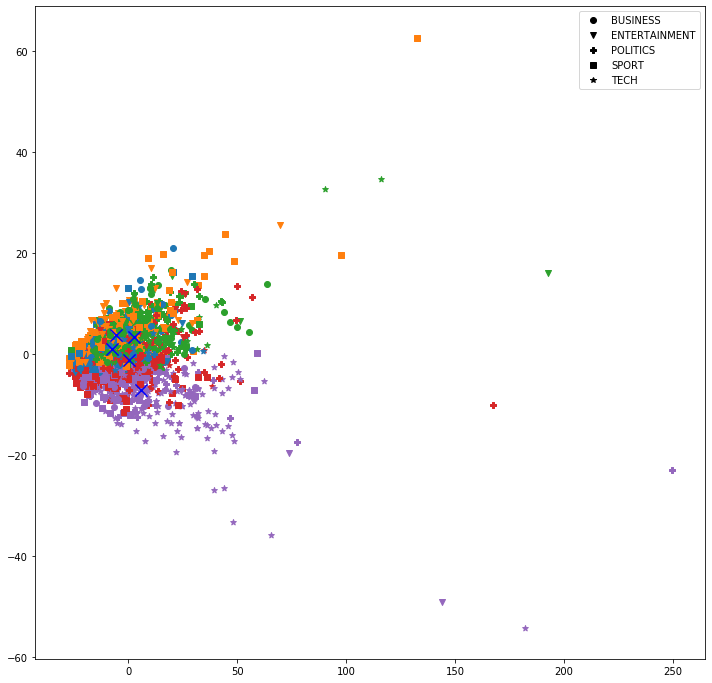

In [34]:
bowVectorizer = CountVectorizer(max_features=1000)

trainX = bowVectorizer.fit_transform(trainDataSet['CONTENT'])

# convert trainX into list of arrays
vectorsTrainX = [np.array(f) for f in trainX.toarray()]
labels, clusters = KmeansClustering(vectorsTrainX, 5, 20)
principalComponentAnalysis(2, trainX.toarray(), labels, clusters)

- #### Tf-idf vectorization

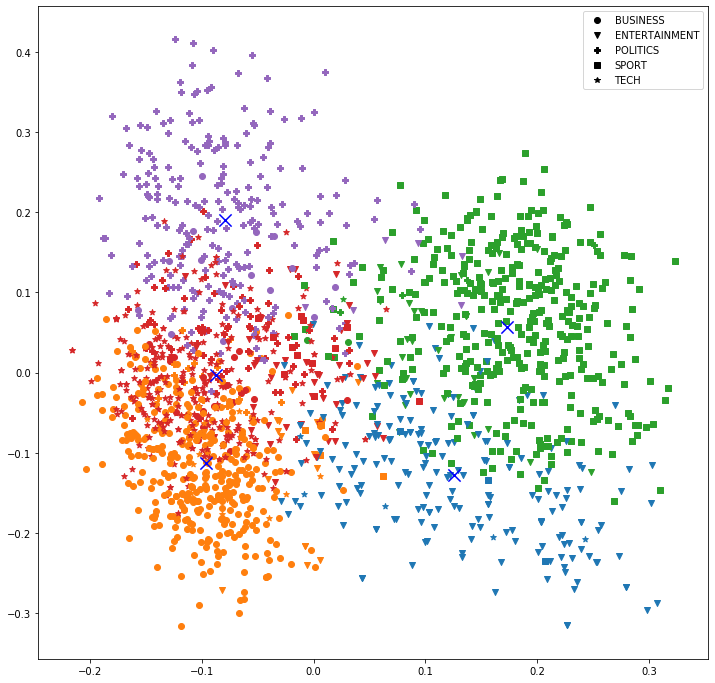

In [35]:
tfIdfVectorizer = TfidfVectorizer(max_features=1000)

trainX = tfIdfVectorizer.fit_transform(trainDataSet['CONTENT'])

# convert trainX into list of arrays
vectorsTrainX = [np.array(f) for f in trainX.toarray()]
labels, clusters = KmeansClustering(vectorsTrainX, 5, 40)
principalComponentAnalysis(2, trainX.toarray(), labels, clusters)

  - #### Word embeddings vectorization

Read pre-trained Word Embeddings

Load Google's pre-trained Word2Vec model.

In [36]:
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  
vec_size = 300

In [37]:
def sample_floats(low=-1.0, high=1.0, k=1):
    """ 
    Return a k-length list of unique random floats in the range of low <= x <= high
    """
    result = []
    seen = set()
    for i in range(k):
        x = random.uniform(low, high)
        while x in seen:
            x = random.uniform(low, high)
        seen.add(x)
        result.append(x)
    return result

def wordEmbeddingsVectorizer(data):
    """
    Vectorize the data based on the model we loaded.
    """
    text_vec = []
    for index, row in data.iterrows():
        text = row['CONTENT']
        text_len = len(text)
        if text_len == 0:
            article_vec = sample_floats(-5.0, 5.0, vec_size)
            text_vec.append(article_vec)
            continue
        tokens = word_tokenize(text)
        if tokens[0] in model_w2v.vocab:
            article_vec = model_w2v[tokens[0]]
        else:
            article_vec = sample_floats(-5.0, 5.0, vec_size)
        for token in tokens[1:]:
            if token in model_w2v.vocab:
                article_vec = list(map(add, article_vec, model_w2v[token]))
            else:
                article_vec = list(map(add, article_vec, sample_floats(-5.0, 5.0, vec_size)))
        final_article_vec = [i / text_len for i in article_vec]
        text_vec.append(final_article_vec)

    return np.array(text_vec)

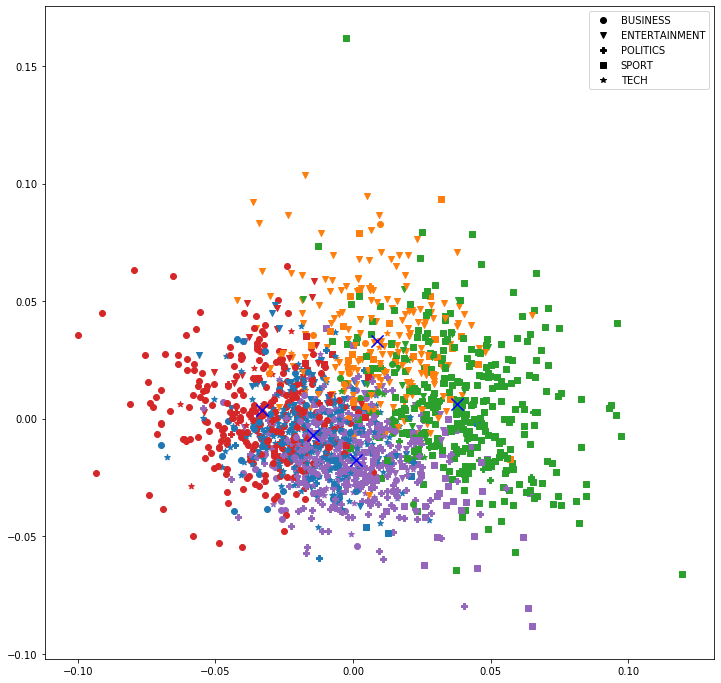

In [38]:
trainX = wordEmbeddingsVectorizer(trainDataSet)

# convert trainX, testX into list of arrays
vectorsTrainX = [np.array(f) for f in trainX]

labels, clusters = KmeansClustering(vectorsTrainX, 5, 40)
principalComponentAnalysis(2, trainX, labels, clusters)